Pandas analysis

1. Create a Pandas DataFrame reading N rows of the data/data_000637.txt dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [23]:
import pandas as pd
import numpy as np

file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name)
data_rows = data.shape[0]
N = 10000 # np.random.randint(10000, data_rows)
data_N = pd.read_csv(file_name, nrows=(N))
data_N

# 1 done

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11
9996,1,0,60,3869200267,701,5
9997,1,0,59,3869200267,707,23
9998,1,0,63,3869200267,706,15


2. Estimate the number of BX in a ORBIT (the value x).

Hint: check when the BX counter reaches the maximum value before being reset to 0.

In [24]:
x = data.loc[:,'BX_COUNTER'].max()
print(x)
# 2 done

3563


3. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [25]:
from datetime import datetime as dt

# compute the absolute time in nanoseconds
sum_time = data['ORBIT_CNT']*x*25 + data['BX_COUNTER']*25 + data['TDC_MEAS']*25/30

# create the new column and concatenate to data and print it
sum_time_data = pd.DataFrame(sum_time, columns=['ABSOLUTE_TIME'])
data_new =[data, sum_time_data]
print(pd.concat(data_new, axis=1))

# convert the new column to a timeseries
abs_time = pd.to_datetime(sum_time, unit = 'ns')
print("The corresponding time series is: ")
print(abs_time)

# 3 done

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0           1     0          123  3869200167        2374        26   
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
...       ...   ...          ...         ...         ...       ...   
1310715     1     0           62  3869211171         762        14   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

         ABSOLUTE_TIME  
0         3.446490e+14  
1         3.446490e+14  
2         3.446490e+14  
3         3.446490e+14  
4         3.446490e+14  
...      

4. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [26]:
d_time = pd.to_timedelta(sum_time) # time hous, minutes and seconds
print(d_time)
data['ABSOLUTE_TIME'] = d_time

# 4 done (sure?)

0         3 days 23:44:09.004934896
1         3 days 23:44:09.004934897
2         3 days 23:44:09.004939373
3         3 days 23:44:09.004939490
4         3 days 23:44:09.004944545
                     ...           
1310715   3 days 23:44:09.985075886
1310716   3 days 23:44:09.985075909
1310717   3 days 23:44:09.985075925
1310718   3 days 23:44:09.985076050
1310719   3 days 23:44:09.985075890
Length: 1310720, dtype: timedelta64[ns]


5. Use the .groupby() method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [27]:
occurrences = data.groupby("TDC_CHANNEL").count()["HEAD"]
noisy_ch=occurrences.sort_values(ascending=False) # sort values
print(occurrences)
print(noisy_ch[0:3]) # print the three noisiest

# 5 done

TDC_CHANNEL
1       29653
2       34271
3       23463
4       28755
5       16435
        ...  
129        37
130        71
137        68
138        70
139    108059
Name: HEAD, Length: 133, dtype: int64
TDC_CHANNEL
139    108059
64      66020
63      64642
Name: HEAD, dtype: int64


6. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [28]:
non_empty_orbits = data.groupby('ORBIT_CNT').count()
orbits_number = len(non_empty_orbits)
print("The number of non-empty orbits is " + str(orbits_number))

# 6 done

The number of non-empty orbits is 11001


7. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [29]:
unique_orbits_139 = np.unique(data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'])
print("We have " + str(len(unique_orbits_139)) + " unique orbits with at least one measurements with TDC_CHANNEL = 139.")

# 7 done

We have 10976 unique orbits with at least one measurements with TDC_CHANNEL = 139.


8. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [30]:
FPGA_0 = pd.Series(data.loc[data['FPGA']==0, 'TDC_CHANNEL'].value_counts())
FPGA_1 = pd.Series(data.loc[data['FPGA']==1,'TDC_CHANNEL'].value_counts())

print("Series with FPGA == 0 and TDC channel as index:")
print(FPGA_0)

print("\nSeries with FPGA == 1 and TDC channel as index:")
print(FPGA_1)
# 8 done

Series with FPGA == 0 and TDC channel as index:
139    75617
64     64581
63     63724
61     48699
62     48275
       ...  
130       33
137       32
30         4
129        2
39         1
Name: TDC_CHANNEL, Length: 124, dtype: int64

Series with FPGA == 1 and TDC channel as index:
2      32669
139    32442
1      28438
4      26403
3      21970
       ...  
9         80
130       38
138       36
137       36
129       35
Name: TDC_CHANNEL, Length: 132, dtype: int64


9. Optional: Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0, 0.5, 'Number of counts')

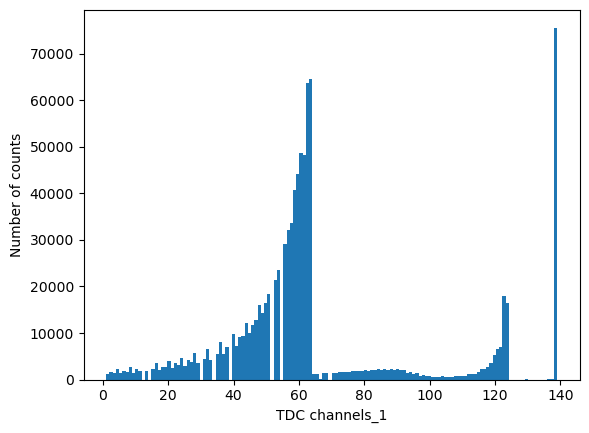

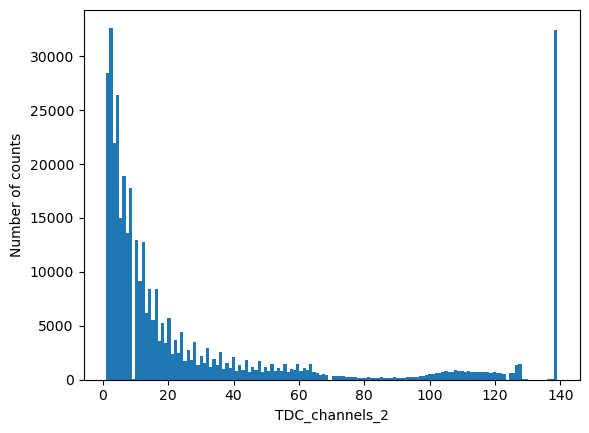

In [31]:
import matplotlib.pyplot as plt

TDC_channel_1 = data[data["FPGA"] == 0]["TDC_CHANNEL"]
plt.figure(0)
plt.hist(TDC_channel_1, bins = 140)
plt.xlabel("TDC channels_1")
plt.ylabel("Number of counts")

TDC_channel_2 = data[data["FPGA"] == 1]["TDC_CHANNEL"]
plt.figure(1)
plt.hist(TDC_channel_2, bins = 140)
plt.xlabel("TDC_channels_2")
plt.ylabel("Number of counts")
# 9 done